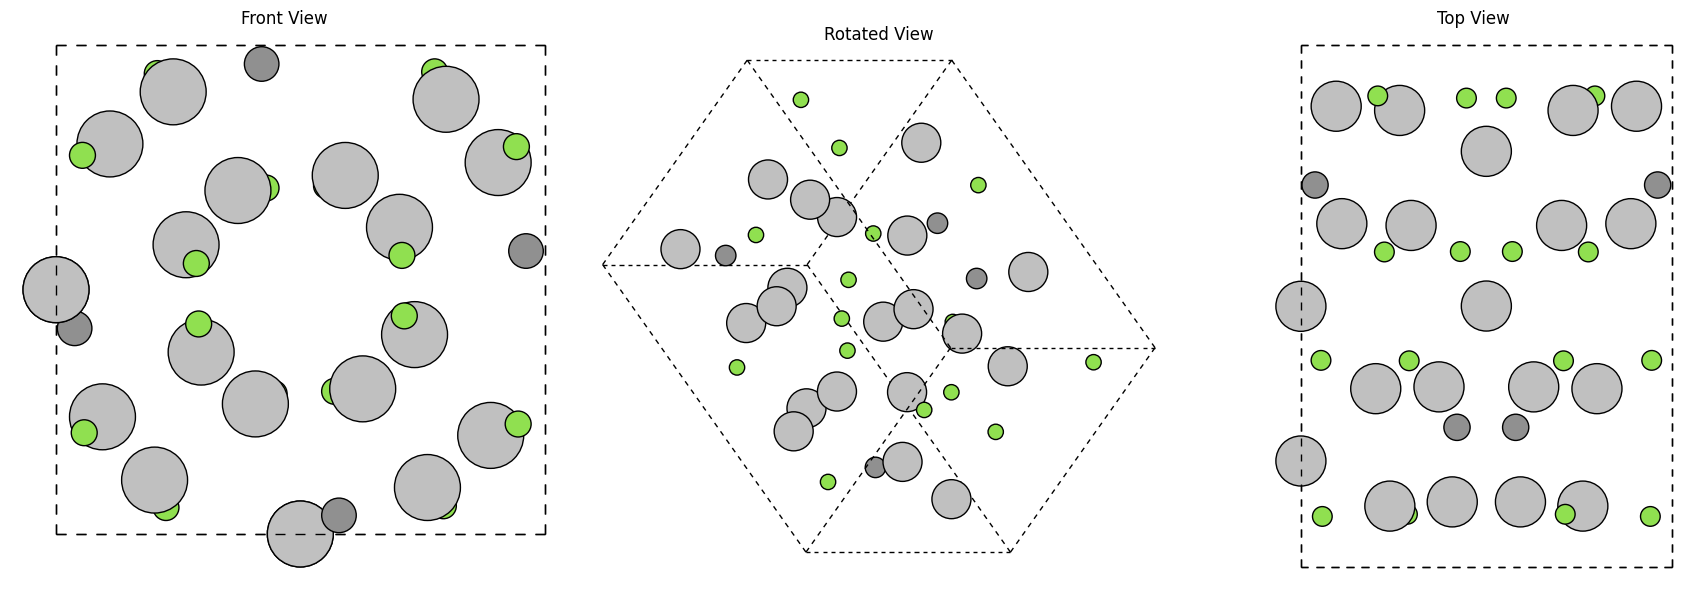

In [1]:
from ase.io import read
from ase.visualize.plot import plot_atoms
import matplotlib.pyplot as plt

atoms = read("Ag10C2F8_407646.cif")

fig = plt.figure(figsize=(18, 6))

# View 1: Front
ax1 = fig.add_subplot(131)
plot_atoms(atoms, ax1, radii=0.35)
ax1.set_title("Front View")
ax1.axis("off")

# View 2: Rotated
ax2 = fig.add_subplot(132)
plot_atoms(atoms, ax2, radii=0.35, rotation=('45x,45y,0z'))
ax2.set_title("Rotated View")
ax2.axis("off")

# View 3: Top
ax3 = fig.add_subplot(133)
plot_atoms(atoms, ax3, radii=0.35, rotation=('90x,0y,0z'))
ax3.set_title("Top View")
ax3.axis("off")

plt.tight_layout()
plt.show()

In [4]:
import re
from dataclasses import dataclass

# ============================================
# Input file
# ============================================

file_path = "/home/nikolai/OrbitMat/Ag10C2F8_407646-eigenvalues-1_0.MOLog"

@dataclass
class BandState:
    k: int
    eig_ev: float
    occ: float


# ============================================
# Parser for CP2K MOLog eigenvalue files
# ============================================

def parse_cp2k_eigenvalues(path):
    """
    Parses CP2K MO eigenvalue block for *all k-points*.
    Returns a list of BandState(k, eig_ev, occ).
    """

    records = []
    current_k = None

    # Detect k-point headers
    kp_pattern = re.compile(r"K POINT\s+(\d+)")

    # Detect MO lines (index, eig [Ha], eig [eV], occ)
    mo_pattern = re.compile(
        r"^\s*MO\|\s*(\d+)\s+([\-0-9.]+)\s+([\-0-9.]+)\s+([0-9.]+)"
    )

    with open(path, "r") as f:
        for line in f:
            # K-point header
            m_k = kp_pattern.search(line)
            if m_k:
                current_k = int(m_k.group(1))

            # Parse MO eigenvalue line
            m = mo_pattern.match(line)
            if m:
                idx, eig_ha, eig_ev, occ = m.groups()
                records.append(
                    BandState(
                        k=current_k,
                        eig_ev=float(eig_ev),
                        occ=float(occ)
                    )
                )

    return records


# ============================================
# Band gap analysis
# ============================================

def compute_band_gap(states):
    """
    Given a list of BandState objects, determine:
    - VBM (max occupied)
    - CBM (min empty)
    - indirect gap
    - direct gap
    - whether direct/indirect
    """

    if not states:
        raise RuntimeError("No eigenvalues parsed! Check regex or file format.")

    occupied = [s for s in states if s.occ > 1e-6]
    empty    = [s for s in states if s.occ < 1e-6]

    if not occupied or not empty:
        raise RuntimeError("No occupied or unoccupied states found.")

    # Fundamental edges
    vbm = max(occupied, key=lambda s: s.eig_ev)
    cbm = min(empty, key=lambda s: s.eig_ev)

    indirect_gap = cbm.eig_ev - vbm.eig_ev

    # Direct gap at each k-point
    direct_gaps = []
    ks = set(s.k for s in states)

    for k in ks:
        occ_k = [s for s in occupied if s.k == k]
        emp_k = [s for s in empty    if s.k == k]

        if not occ_k or not emp_k:
            continue

        v_k = max(occ_k, key=lambda s: s.eig_ev)
        c_k = min(emp_k, key=lambda s: s.eig_ev)
        direct_gaps.append(c_k.eig_ev - v_k.eig_ev)

    direct_gap = min(direct_gaps) if direct_gaps else None

    is_direct = (direct_gap is not None) and abs(indirect_gap - direct_gap) < 1e-6

    return vbm, cbm, indirect_gap, direct_gap, is_direct


# ============================================
# Run everything
# ============================================

states = parse_cp2k_eigenvalues(file_path)
vbm, cbm, indirect_gap, direct_gap, is_direct = compute_band_gap(states)

print("\n=========== BAND GAP REPORT ===========")
print(f"VBM: {vbm.eig_ev:.6f} eV   at k = {vbm.k}")
print(f"CBM: {cbm.eig_ev:.6f} eV   at k = {cbm.k}")
print("---------------------------------------")
print(f"Indirect (fundamental) gap: {indirect_gap:.6f} eV")
print(f"Smallest direct gap:        {direct_gap:.6f} eV")
print("---------------------------------------")

if is_direct:
    print("Result: **DIRECT band gap semiconductor**")
else:
    print("Result: **INDIRECT band gap semiconductor**")

print("========================================\n")


=========== BAND GAP REPORT ===========
VBM: 3.372498 eV   at k = 62
CBM: 5.420062 eV   at k = 63
---------------------------------------
Indirect (fundamental) gap: 2.047564 eV
Smallest direct gap:        2.049721 eV
---------------------------------------
Result: **INDIRECT band gap semiconductor**

